# Auswertung der Seattle AirBNB-Daten von 2016

![KI-Rendering](seattle3.png "Bild wurde mit https://huggingface.co/spaces/black-forest-labs/FLUX.1-dev generiert")

AirBNB hat viele seiner Daten veröffentlicht. Die in dieser Auswertung untersuchten Daten stammen von 
https://www.kaggle.com/datasets/airbnb/seattle/data
und sind in der public domain unter CC0 verfügbar.

Die Auswertung kann angesehen werden: 
* [ohne Python-Code](index.html)
* [mit Python-Code](seattle_airbnb.html)


## Inhaltsverzeichnis



1. [Beschreibung der DataFrames und ihrer Spalten](#beschreibung-der-dataframes-und-ihrer-spalten)
1. [Sind die Preise vom Stadtteil abhängig?](#sind-die-preise-vom-stadtteil-abhaengig)
1. [Gibt es eine Abhängigkeit der Preise von Feiertagen?](#gibt-es-eine-abhaengigkeit-der-preise-von-feiertagen)
1. [Haben erfahrene Hosts mit mehreren Angeboten bessere Bewertungen?](#haben-erfahrene-hosts-mit-mehreren-angeboten-bessere-bewertungen)




In [1]:
# Bibliotheken importieren

import pandas as pd  # Importieren von Pandas für die Datenanalyse
import numpy as np  # Importieren von NumPy für numerische Operationen
import matplotlib.pyplot as plt  # Importieren von Matplotlib für die Datenvisualisierung
import holidays # Importieren von holidays für Feiertage
import seaborn as sns # Importieren von seaborn für die Datenvisualisierung
import geopandas as gpd # Importieren von geopandas für die Geodatenanalyse
import geodatasets as gd # Importieren von geodataset für die Geodatenanalyse


# Daten einlesen
calendar = pd.read_csv('./data/calendar.csv')
listings = pd.read_csv('./data/listings.csv')
reviews = pd.read_csv('./data/reviews.csv')

# Erste Übersicht

## Beschreibung der DataFrames und ihrer Spalten

### calendar DataFrame

Die Tabelle enthält Informationen über die Verfügbarkeit und die Preise von Airbnb-Listings in Seattle. Hier ist eine detaillierte Beschreibung der Spalten:

**listing_id**
: Eine eindeutige Identifikationsnummer für jedes Airbnb-Listing. Diese ID ermöglicht es, jedes Listing eindeutig zu identifizieren.

**date**
: Das Datum, an dem die Verfügbarkeit und der Preis des Listings aufgezeichnet wurden.

**available**
: Ein Indikator dafür, ob das Listing an dem angegebenen Datum verfügbar ist. 't' steht für verfügbar (true) und 'f' steht für nicht verfügbar (false).

**price**
: Der Preis des Listings an dem angegebenen Datum.

Diese Tabelle kann verwendet werden, um die Verfügbarkeit und Preisänderungen von Airbnb-Listings über die Zeit zu analysieren.

### listings DataFrame

Die Daten enthalten Informationen zu Airbnb-Listings in Seattle. Sie umfassen Details zu den _Listings_ selbst, wie ID, URL, Name, Beschreibung, Standort (Straße, Stadt, Bundesstaat, Postleitzahl, Koordinaten) und _Art der Unterkunft_ (z.B. Zimmer- oder Unterkunftstyp, Anzahl der Schlafzimmer und Betten, Annehmlichkeiten, Preis und Verfügbarkeit). Zusätzlich gibt es Informationen über die _Hosts_, wie deren ID, Name, Standort, Verifizierungen und Bewertungen. Bewertungen und Feedback zu den Listings werden ebenfalls erfasst, einschließlich der Anzahl der Bewertungen und verschiedener Bewertungskriterien (z.B. Sauberkeit, Kommunikation). Weitere Spalten betreffen Buchungsbedingungen und Anforderungen an Gäste.

### reviews DataFrame

Die Tabelle enthält schriftliche Bewertungen der Airbnb-Listings mit ID des Reviewers und einem Datum. Es sind keine numerischen Bewertungen enthalten




# Gibt es eine Abhängigkeit der Preise von Feiertagen?

Für diese Analyse müssen wir die Daten aus dem Calendar-Dataframe mit den Angaben zu den öffentlichen Feiertagen im US-Bundesstaat Washington (WA) kombinieren. Wir wollen die Preise an allen Tagen vor einem Feirtag oder Wochenendtag mit den übrigen Preisen vergleichen.

Werden Unterkünfte teurer, wenn man am nächsten Tag ausschlafen kann?

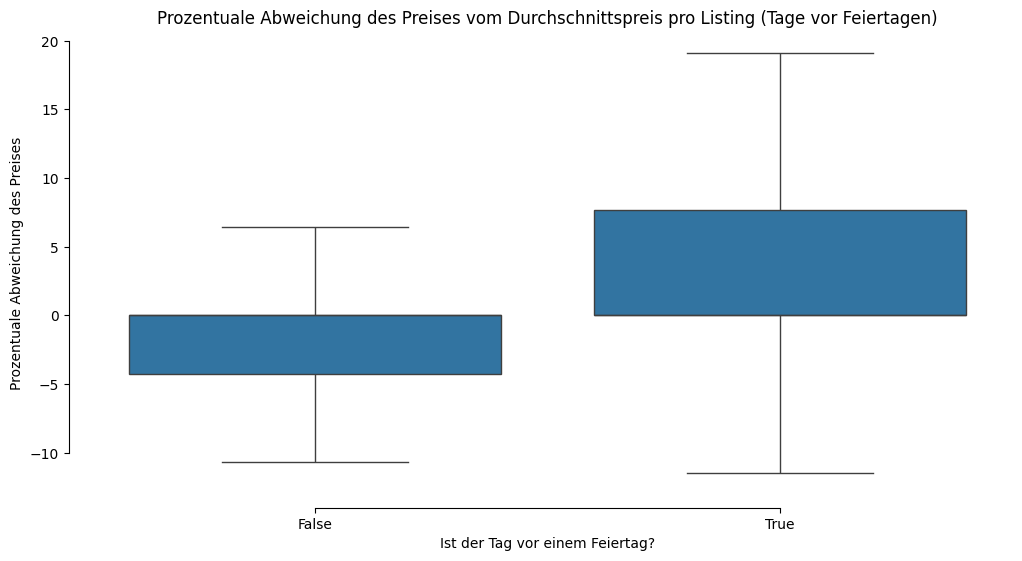

In [2]:




# aufbereiten der csv daten
calendar['_price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)
calendar['_date'] = pd.to_datetime(calendar['date'])
calendar['_available'] = calendar['available'].map({'t': True, 'f': False})

# Berechnen des Durchschnittspreises pro Listing (pandas ignoriert automatisch NaN-Werte)
average_price_per_listing = calendar.groupby('listing_id')['_price'].mean().reset_index()
average_price_per_listing.columns = ['listing_id', 'average_price']

# Zusammenführen der berechneten Durchschnittspreise mit dem ursprünglichen DataFrame
calendar = calendar.merge(average_price_per_listing, on='listing_id', how='left')

# Abweichung des Preises vom Durchschnittspreis pro listing berechnen
calendar['price_deviation'] = calendar['_price'] - calendar['average_price']

# prozentuale Abweichung des Preises vom Durchschnittspreis pro listing berechnen
calendar['price_deviation_percentage'] = calendar['price_deviation'] / calendar['average_price'] * 100

# Funktion zur Überprüfung, ob ein Datum ein Feiertag ist

us_holidays = holidays.US(state='WA')

def is_holiday(date):
    return date in us_holidays

# Spalte erstellen, die angibt, ob das Datum ein arbeitsfreier Tag ist
calendar['is_holiday_or_weekend'] = calendar['_date'].apply(lambda x: x.weekday() >= 5 or is_holiday(x))

# boolean Spalte erstellen, die angibt, ob das Datum direkt vor einem arbeitsfreien Tag liegt  
calendar['is_day_before_holiday'] = calendar['is_holiday_or_weekend'].shift(-1)
# NaN Werte in der letzten Zeile durch True ersetzen (1.1. ist ein Feiertag)
with pd.option_context('future.no_silent_downcasting', True):
    calendar['is_day_before_holiday'] = calendar['is_day_before_holiday'].fillna(True).infer_objects()


# zwei candlestick-diagramme erstellen. prozentuale Abweichung des Preises vom Durchschnittspreis pro listing getrennt nach is_day_before_holiday.
plt.figure(figsize=(12, 6))
# außreißer ausblenden
sns.boxplot(x='is_day_before_holiday', y='price_deviation_percentage', data=calendar, showfliers=False)
sns.despine(offset=10, trim=True)
plt.title('Prozentuale Abweichung des Preises vom Durchschnittspreis pro Listing (Tage vor Feiertagen)')
plt.xlabel('Ist der Tag vor einem Feiertag?')
plt.ylabel('Prozentuale Abweichung des Preises')
plt.show()




Im Diagramm sieht man, dass die Abweichung vom Durchschnittspreis (je Listing) vor einem Feiertag deutlich höher sind, als wenn der folgende Tag ein normaler Arbeitstag ist.

Vor einem Arbeitstag sind Rabatte üblich, vor einem Feiertag/Wochenende Preissteigerungen um ca. 5%.

# Sind die Preise vom Stadtteil abhängig?

Durch zusammenführen der Werte aus dem Calendar-Dataframe und dem Listings-Dataframe können wir den durchschnittlichen Preis pro Stadtteil (neighbourhood) ausrechnen.

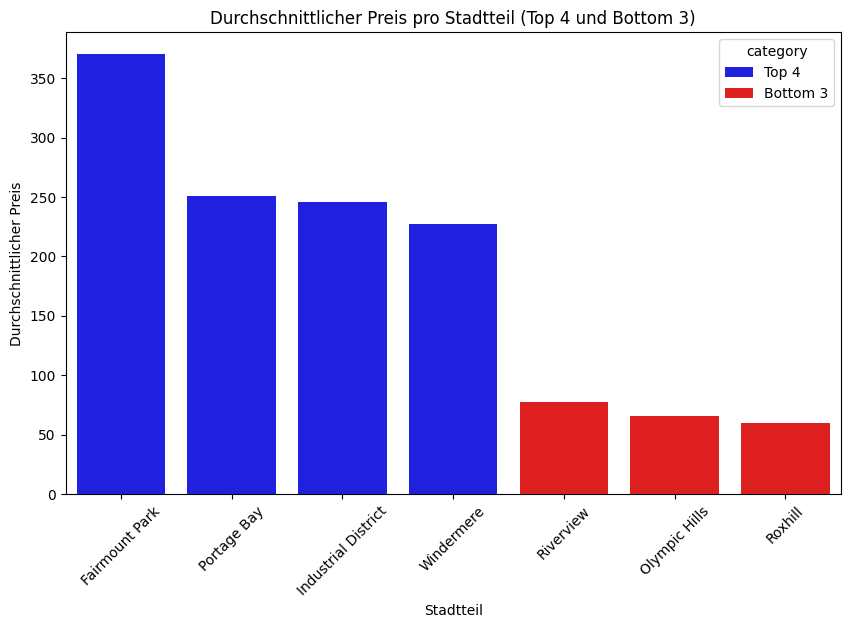

In [3]:
# Preis-Spalte im calendar DataFrame bereinigen und in float umwandeln
calendar['price'] = calendar['price'].replace('[\\$,]', '', regex=True).astype(float)

# Zusammenführen der DataFrames calendar und listings anhand der listing_id
merged_df = pd.merge(calendar, listings[['id', 'neighbourhood']], left_on='listing_id', right_on='id', how='left')

# Berechnen des durchschnittlichen Preises pro Stadtteil
average_price_per_neighbourhood = merged_df.groupby('neighbourhood')['price'].mean().reset_index()
average_price_per_neighbourhood.columns = ['neighbourhood', 'average_price']

# Sortieren der Stadtteile nach durchschnittlichem Preis
sorted_neighbourhoods = average_price_per_neighbourhood.sort_values(by='average_price', ascending=False)

# Auswählen der höchsten 4 und niedrigsten 3 Stadtteile
top_4_neighbourhoods = sorted_neighbourhoods.head(4)
bottom_3_neighbourhoods = sorted_neighbourhoods.tail(3)

# Zusammenführen der ausgewählten Stadtteile
selected_neighbourhoods = pd.concat([top_4_neighbourhoods, bottom_3_neighbourhoods])

# Balkendiagramm erstellen mit unterschiedlichen Farben für Top 4 und Bottom 3 Stadtteile
plt.figure(figsize=(10, 6))
colors = ['blue'] * 4 + ['red'] * 3
selected_neighbourhoods['category'] = ['Top 4'] * 4 + ['Bottom 3'] * 3
sns.barplot(x='neighbourhood', y='average_price', hue='category', data=selected_neighbourhoods, dodge=False, palette={'Top 4': 'blue', 'Bottom 3': 'red'})
plt.title('Durchschnittlicher Preis pro Stadtteil (Top 4 und Bottom 3)')
plt.xlabel('Stadtteil')
plt.ylabel('Durchschnittlicher Preis')
plt.xticks(rotation=45)
plt.show()


Die Preise in den verschiedenen Stadtteilen von Seattle unterscheiden sich deutlich. Mit Abstand am teuersten sind Unterkünfte in Fairmount Park.

# Haben erfahrene Hosts mit mehreren Angeboten bessere Bewertungen?

Wenn Hosts mehrere Unterkünfte anbieten, sollten sie Erfahrung sammeln können und das Angebot besser an die Bedürfnisse der Besucher anpassen können.

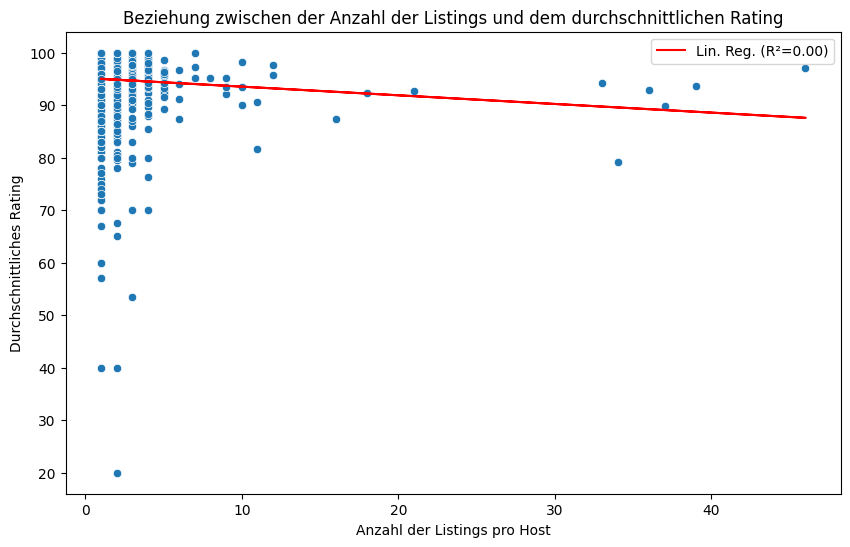

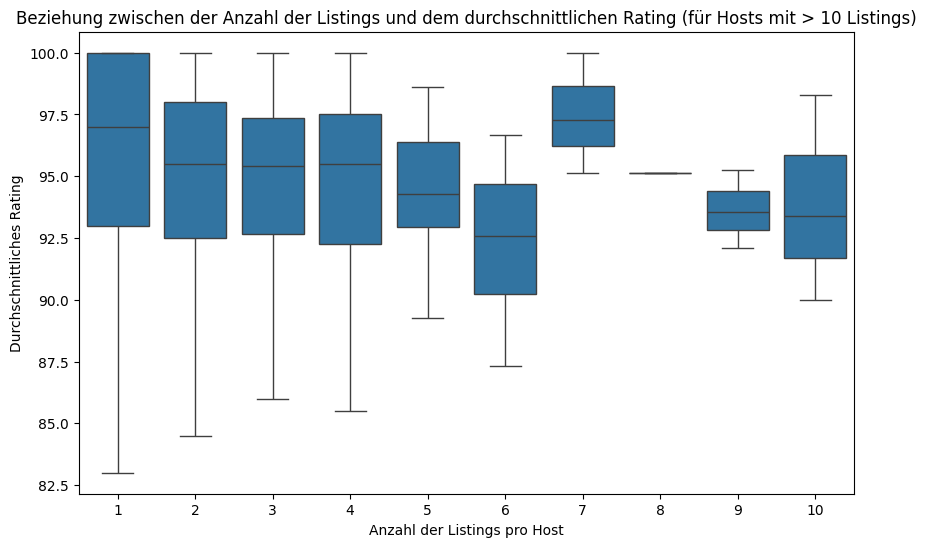

In [4]:
# Anzahl der Listings pro Host berechnen
listings_per_host = listings.groupby('host_id').size().reset_index(name='listings_count')

# Durchschnittliches Rating pro Host berechnen
average_rating_per_host = listings.groupby('host_id')['review_scores_rating'].mean().reset_index(name='average_rating')

# Zusammenführen der DataFrames listings_per_host und average_rating_per_host anhand der host_id
listings_and_ratings = pd.merge(listings_per_host, average_rating_per_host, on='host_id', how='left')



# Berechnen der linearen Regression, um die Beziehung zwischen der Anzahl der Listings und dem durchschnittlichen Rating zu approximieren
from scipy.stats import linregress

# Entfernen von NaN-Werten
listings_and_ratings_clean = listings_and_ratings.dropna(subset=['average_rating'])

# Lineare Regression berechnen
slope, intercept, r_value, p_value, std_err = linregress(listings_and_ratings_clean['listings_count'], listings_and_ratings_clean['average_rating'])




# Scatterplot mit Regressionslinie erstellen
plt.figure(figsize=(10, 6))
sns.scatterplot(x='listings_count', y='average_rating', data=listings_and_ratings_clean)
plt.plot(listings_and_ratings_clean['listings_count'], intercept + slope * listings_and_ratings_clean['listings_count'], 'r', label=f'Lin. Reg. (R²={r_value**2:.2f})')



plt.title('Beziehung zwischen der Anzahl der Listings und dem durchschnittlichen Rating')
plt.xlabel('Anzahl der Listings pro Host')
plt.ylabel('Durchschnittliches Rating')
plt.legend()
plt.show()

# Filter the data to include only hosts with more than 10 listings
filtered_data = listings_and_ratings_clean[listings_and_ratings_clean['listings_count'] <= 10]

# Boxplot für gefilterte Daten erstellen
plt.figure(figsize=(10, 6))
sns.boxplot(x='listings_count', y='average_rating', data=filtered_data, showfliers=False)
plt.title('Beziehung zwischen der Anzahl der Listings und dem durchschnittlichen Rating (für Hosts mit > 10 Listings)')
plt.xlabel('Anzahl der Listings pro Host')
plt.ylabel('Durchschnittliches Rating')
plt.show()


Die Durchschnittliche Bewertung scheint keinen offensichtlichen Zusammenhang mit der Anzahl der Listings pro Host zu haben. Die niedrigen Bewertungen scheinen sich mit der Anzahl der Listings nach oben zu Bewegen. Die Durchschnittliche Bewertung sinkt aber sogar leicht (rote Regressionsline). Gerade bei Hosts mit vielen Listings (>10) ist aber die Datenlage recht spärlich und die Aussagekraft fraglich.